In [1]:
import pandas as pd
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch
import sqlite3
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import sqlite3

# Caminho para o banco de dados
db_path = '/Users/leonardooliveira/Desktop/PBI-EXAI/Projeto-BI/preparacao/Experimentai.db'
conn = sqlite3.connect(db_path)

# Leitura das tabelas do banco de dados
df_gosto = pd.read_sql_query("SELECT * FROM dim_gosto_base_nova;", conn)
df_demografico = pd.read_sql_query("SELECT * FROM dim_demografico_base_nova;", conn)
df_cliente_fato = pd.read_sql_query("SELECT * FROM fato_base_nova;", conn)

# Fechar a conexão com o banco de dados
conn.close()

# Fazer o merge usando outer join para incluir todas as linhas
base = pd.merge(df_cliente_fato, df_gosto, on='id_gosto_base', how='inner')
base = pd.merge(base, df_demografico, on='id_demografico_base', how='inner')
base.isnull().sum()


id_fato_base                0
id_demografico_base         0
id_gosto_base               0
data_inscricao              0
rede_social                 0
renda_id                    0
objetivo_id                 0
tem_cupom                   0
assinantes                  0
moda                        0
pessoa_artistica            0
maquiagem                   0
brinquedos_ou_jogos         0
esportes                    0
tem_pet                     0
decorar_casa                0
alimento_saudavel           0
gastronomia                 0
carro                       0
bebida_alcoolica            0
cuidados_pessoais           0
tecnologia                  0
mae_ou_pai                  0
influencer                  0
restricoes_alimentares      0
cluster                     0
cluster_predito             0
nome                        0
sobrenome                   0
data_nascimento             6
genero                      0
cidade                      0
estado                      0
bairro    

In [3]:
base.columns

Index(['id_fato_base', 'id_demografico_base', 'id_gosto_base',
       'data_inscricao', 'rede_social', 'renda_id', 'objetivo_id', 'tem_cupom',
       'assinantes', 'moda', 'pessoa_artistica', 'maquiagem',
       'brinquedos_ou_jogos', 'esportes', 'tem_pet', 'decorar_casa',
       'alimento_saudavel', 'gastronomia', 'carro', 'bebida_alcoolica',
       'cuidados_pessoais', 'tecnologia', 'mae_ou_pai', 'influencer',
       'restricoes_alimentares', 'cluster', 'cluster_predito', 'nome',
       'sobrenome', 'data_nascimento', 'genero', 'cidade', 'estado', 'bairro',
       'idade', 'faixa_etaria'],
      dtype='object')

In [4]:
del base['id_fato_base']
del base['data_inscricao']
del base['id_gosto_base']
del base['id_demografico_base']
del base['faixa_etaria']
del base['nome']
del base['sobrenome']


In [5]:
base = base.dropna()

In [6]:
assinantes = base[base['assinantes'] == 1]


In [7]:
assinantes.head()

,rede_social,renda_id,objetivo_id,tem_cupom,assinantes,moda,pessoa_artistica,maquiagem,brinquedos_ou_jogos,esportes,...,influencer,restricoes_alimentares,cluster,cluster_predito,data_nascimento,genero,cidade,estado,bairro,idade
5,0,Superior a R$24.000,Quero dar a minha opinião sobre produtos,0,1,1,0,0,1,1,...,1,Amendoim,0.0,-1,2004-03-30 00:00:00,Feminino,Piracaia,São Paulo,Centro,20.0
425,0,R$0 - 3.000,Quero dar a minha opinião sobre produtos,0,1,1,1,1,1,1,...,1,Outro,2.0,-1,2001-03-19 00:00:00,Feminino,Sao paulo,São Paulo,Santo Amaro,23.0
575,0,R$3.000 - 8.000,Quero descobrir novos produtos para comprar,0,1,1,0,1,1,1,...,0,,2.0,-1,1994-03-09 00:00:00,Feminino,São Paulo,São Paulo,Chácara Califórnia,30.0
621,0,R$8.000 - 16.000,Quero dar a minha opinião sobre produtos,0,1,1,1,1,0,1,...,1,,1.0,-1,1965-09-25 00:00:00,Masculino,Indaiatuba,São Paulo,Jardim Residencial Santa Clara,59.0
675,1,R$0 - 3.000,Quero dar a minha opinião sobre produtos,1,1,1,1,0,1,1,...,1,,2.0,-1,1996-10-19 00:00:00,Feminino,São José dos Campos,São Paulo,Condomínio Royal Park,28.0


In [8]:
assinantes = assinantes[assinantes['idade'] > 47]

In [9]:
assinantes.value_counts()

rede_social  renda_id          objetivo_id                                  tem_cupom  assinantes  moda  pessoa_artistica  maquiagem  brinquedos_ou_jogos  esportes  tem_pet  decorar_casa  alimento_saudavel  gastronomia  carro  bebida_alcoolica  cuidados_pessoais  tecnologia  mae_ou_pai  influencer  restricoes_alimentares     cluster  cluster_predito  data_nascimento      genero     cidade               estado          bairro                          idade
0            R$0 - 3.000       Quero dar a minha opinião sobre produtos     0          1           1     0                 1          1                    0         1        1             1                  0            0      0                 1                  0           0           0           Não tenho restrição        1.0      -1               1974-01-26 00:00:00  Masculino  São José dos Campos  São Paulo       Parque industrial               50.0     1
                                                                           

In [10]:
assinantes['restricoes_alimentares'] = assinantes['restricoes_alimentares'].fillna("Não tenho restrição")

In [11]:
assinantes.isnull().sum()

rede_social               0
renda_id                  0
objetivo_id               0
tem_cupom                 0
assinantes                0
moda                      0
pessoa_artistica          0
maquiagem                 0
brinquedos_ou_jogos       0
esportes                  0
tem_pet                   0
decorar_casa              0
alimento_saudavel         0
gastronomia               0
carro                     0
bebida_alcoolica          0
cuidados_pessoais         0
tecnologia                0
mae_ou_pai                0
influencer                0
restricoes_alimentares    0
cluster                   0
cluster_predito           0
data_nascimento           0
genero                    0
cidade                    0
estado                    0
bairro                    0
idade                     0
dtype: int64

In [12]:
assinantes.columns

Index(['rede_social', 'renda_id', 'objetivo_id', 'tem_cupom', 'assinantes',
       'moda', 'pessoa_artistica', 'maquiagem', 'brinquedos_ou_jogos',
       'esportes', 'tem_pet', 'decorar_casa', 'alimento_saudavel',
       'gastronomia', 'carro', 'bebida_alcoolica', 'cuidados_pessoais',
       'tecnologia', 'mae_ou_pai', 'influencer', 'restricoes_alimentares',
       'cluster', 'cluster_predito', 'data_nascimento', 'genero', 'cidade',
       'estado', 'bairro', 'idade'],
      dtype='object')

In [13]:
assinantes['objetivo_id'] = assinantes['objetivo_id'].apply(lambda x: 1 if x == 'Quero dar a minha opinião sobre produtos' else 0)
assinantes['genero'] = assinantes['genero'].apply(lambda x: 1 if x == 'Feminino' else 0)


In [14]:
assinantes.head(5)

,rede_social,renda_id,objetivo_id,tem_cupom,assinantes,moda,pessoa_artistica,maquiagem,brinquedos_ou_jogos,esportes,...,influencer,restricoes_alimentares,cluster,cluster_predito,data_nascimento,genero,cidade,estado,bairro,idade
621,0,R$8.000 - 16.000,1,0,1,1,1,1,0,1,...,1,,1.0,-1,1965-09-25 00:00:00,0,Indaiatuba,São Paulo,Jardim Residencial Santa Clara,59.0
4917,0,R$8.000 - 16.000,1,0,1,1,1,1,1,0,...,0,Lactose,1.0,-1,1960-10-23 00:00:00,0,Belo Horizonte,Minas Gerais,Goiania,64.0
8089,0,R$0 - 3.000,0,0,1,1,0,1,1,0,...,0,Não tenho restrição,1.0,-1,1975-05-31 00:00:00,1,Campinas,São Paulo,Vila Padre Manoel da Nóbrega,49.0
9666,0,R$0 - 3.000,1,0,1,1,0,1,1,0,...,0,Não tenho restrição,1.0,-1,1974-01-26 00:00:00,0,São José dos Campos,São Paulo,Parque industrial,50.0
11962,0,R$0 - 3.000,1,0,1,1,1,1,1,1,...,0,Não tenho restrição,1.0,-1,1960-12-31 00:00:00,1,Bebedouro,São Paulo,Distrito de Turvinia,63.0


In [15]:
assinantes.columns

Index(['rede_social', 'renda_id', 'objetivo_id', 'tem_cupom', 'assinantes',
       'moda', 'pessoa_artistica', 'maquiagem', 'brinquedos_ou_jogos',
       'esportes', 'tem_pet', 'decorar_casa', 'alimento_saudavel',
       'gastronomia', 'carro', 'bebida_alcoolica', 'cuidados_pessoais',
       'tecnologia', 'mae_ou_pai', 'influencer', 'restricoes_alimentares',
       'cluster', 'cluster_predito', 'data_nascimento', 'genero', 'cidade',
       'estado', 'bairro', 'idade'],
      dtype='object')

In [16]:
features = assinantes[[ 
'esportes',
'cuidados_pessoais',
'gastronomia',
'renda_id',
'genero',
'idade',
'moda',
'decorar_casa',
'tem_pet'
]]

In [17]:
features = pd.get_dummies(features, columns=[
'esportes',
'cuidados_pessoais',
'gastronomia',
'renda_id',
'genero',
'moda',
'decorar_casa',
'tem_pet'
], drop_first=True)

In [18]:
features['idade'] = stats.zscore(features['idade'])

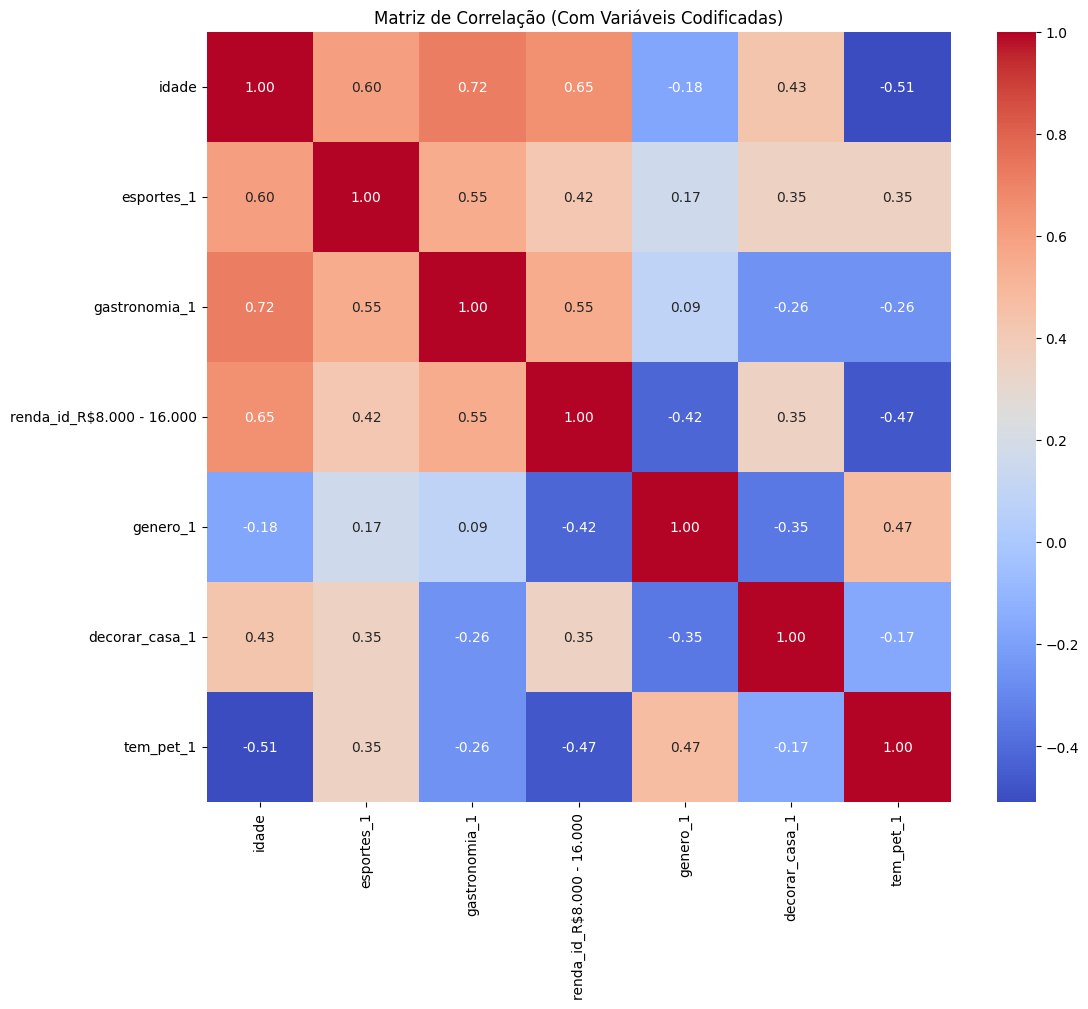

In [19]:
# Calcular a matriz de correlação
correlation_matrix = features.corr()

# Visualizar como heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação (Com Variáveis Codificadas)")
plt.show()


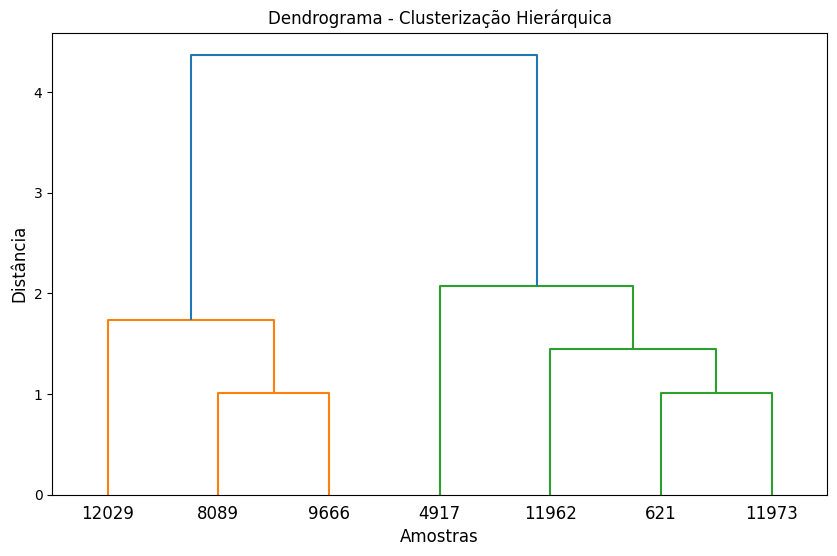

In [20]:
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(
    sch.linkage(features, method='ward', metric='euclidean'),
    orientation='top',  # Altere para 'left', 'right', 'top' ou 'bottom'
    labels=list(features.index) if hasattr(features, 'index') else None
)
plt.title('Dendrograma - Clusterização Hierárquica', fontsize=12)
plt.xlabel('Amostras', fontsize=12)
plt.ylabel('Distância', fontsize=12)
plt.axhline(y=15, color='red', linestyle='--')  # Defina o corte desejado
plt.show()

In [21]:
from sklearn.cluster import AgglomerativeClustering

# Ajustar o modelo de clusterização hierárquica
clusters = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')

# Obter os rótulos dos clusters
assinantes['cluster'] = clusters.fit_predict(features)


In [22]:
assinantes.columns

Index(['rede_social', 'renda_id', 'objetivo_id', 'tem_cupom', 'assinantes',
       'moda', 'pessoa_artistica', 'maquiagem', 'brinquedos_ou_jogos',
       'esportes', 'tem_pet', 'decorar_casa', 'alimento_saudavel',
       'gastronomia', 'carro', 'bebida_alcoolica', 'cuidados_pessoais',
       'tecnologia', 'mae_ou_pai', 'influencer', 'restricoes_alimentares',
       'cluster', 'cluster_predito', 'data_nascimento', 'genero', 'cidade',
       'estado', 'bairro', 'idade'],
      dtype='object')

In [23]:
cluster1 = assinantes[assinantes['cluster'] == 0]
cluster2 = assinantes[assinantes['cluster'] == 1]

In [24]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Ajustar o modelo hierárquico
linkage_matrix = linkage(features, method='ward')

for n_clusters in range(2,7):
    # Ajustar o modelo cortando em n_clusters
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(features)
    
    # Calcular o silhouette score
    silhouette_avg = silhouette_score(features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")



For n_clusters = 2, the silhouette score is 0.44902031753979255
For n_clusters = 3, the silhouette score is 0.3326730493241766
For n_clusters = 4, the silhouette score is 0.23938299529055793
For n_clusters = 5, the silhouette score is 0.16356892106392854
For n_clusters = 6, the silhouette score is 0.06313562920011348


Variância Explicada: [0.32187558 0.21609509]


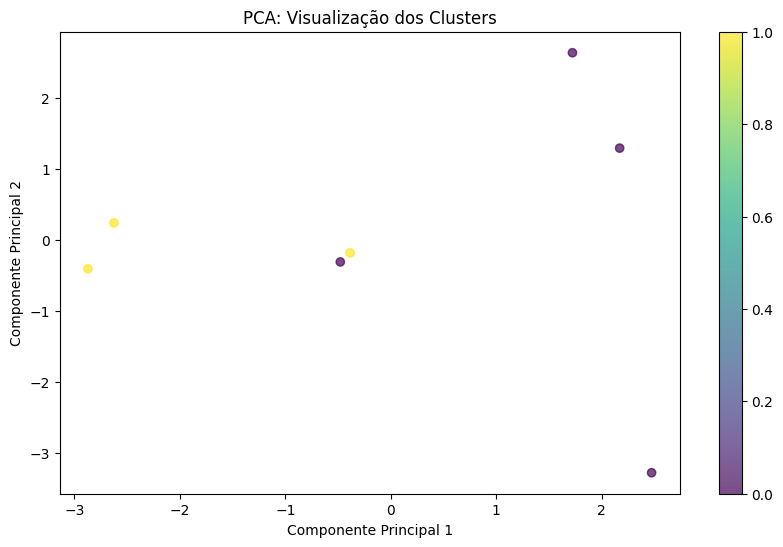

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Selecionar apenas as colunas numéricas presentes no DataFrame
numeric_columns = [
    'rede_social', 'tem_cupom', 
    'moda', 'pessoa_artistica', 'maquiagem', 'brinquedos_ou_jogos',
    'esportes', 'tem_pet', 'decorar_casa', 'alimento_saudavel',
    'gastronomia', 'carro', 'bebida_alcoolica', 'cuidados_pessoais',
    'tecnologia', 'mae_ou_pai', 'influencer', 'genero', 'idade'
]

# Verificar se as colunas existem no DataFrame
numeric_columns = [col for col in numeric_columns if col in assinantes.columns]

# Criar um DataFrame apenas com as colunas numéricas existentes
pca_data = assinantes[numeric_columns].copy()


# Certificar-se de que todas as colunas são numéricas
for col in pca_data.columns:
    if pca_data[col].dtype == 'object':
        # Aplicar codificação (ex.: one-hot encoding ou mapeamento manual)
        pca_data[col] = pd.factorize(pca_data[col])[0]

# Normalizar os dados antes do PCA
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Criar o modelo PCA
pca = PCA(n_components=2)  # Reduzir para 2 componentes principais
pca_result = pca.fit_transform(pca_data_scaled)

# Adicionar os componentes principais ao DataFrame original
assinantes['PCA1'] = pca_result[:, 0]
assinantes['PCA2'] = pca_result[:, 1]

# Visualizar a variância explicada
explained_variance = pca.explained_variance_ratio_
print(f"Variância Explicada: {explained_variance}")

# Criar um scatter plot para visualizar os clusters com os componentes principais
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(assinantes['PCA1'], assinantes['PCA2'], c=assinantes['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('PCA: Visualização dos Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


In [26]:
print(type(assinantes))


<class 'pandas.core.frame.DataFrame'>


Contribuição das Variáveis para os Componentes Principais:
       rede_social     tem_cupom          moda  pessoa_artistica  \
PCA1 -7.053564e-17  1.188878e-16  8.171098e-18          0.412244   
PCA2  1.317152e-17  1.060876e-17 -7.008486e-19          0.048647   

         maquiagem  brinquedos_ou_jogos  esportes   tem_pet  decorar_casa  \
PCA1  7.144440e-18            -0.241159  0.256221 -0.211600      0.037705   
PCA2  5.234361e-18             0.475522 -0.097248 -0.187802      0.026252   

      alimento_saudavel  gastronomia     carro  bebida_alcoolica  \
PCA1               -0.0     0.415374  0.167947          0.260427   
PCA2               -0.0     0.018606  0.382770         -0.253674   

      cuidados_pessoais  tecnologia  mae_ou_pai  influencer    genero  \
PCA1               -0.0    0.253211    0.293996    0.241159 -0.122060   
PCA2               -0.0    0.080360    0.441963   -0.475522  0.245145   

         idade  
PCA1  0.409735  
PCA2  0.163948  


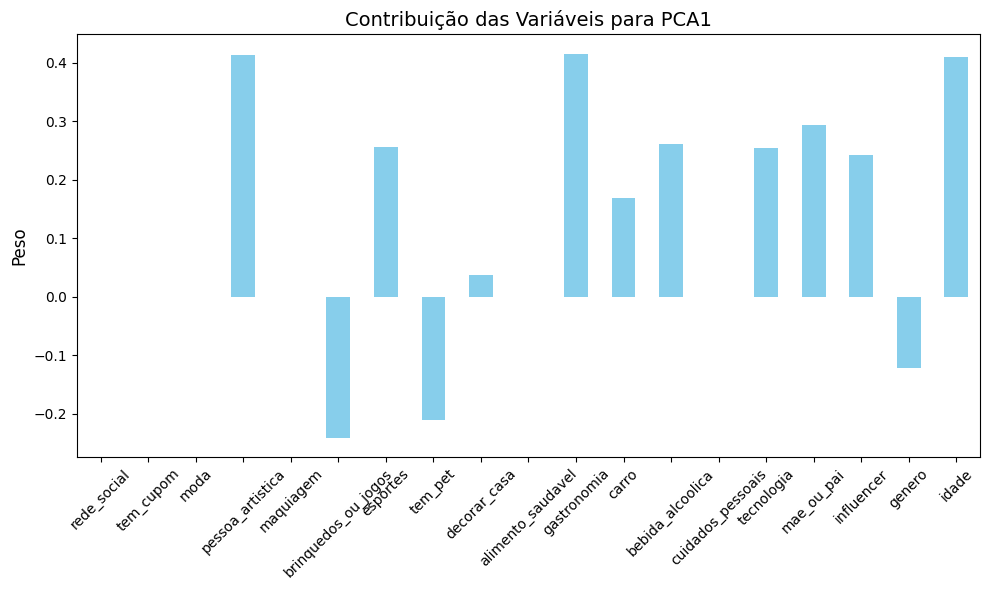

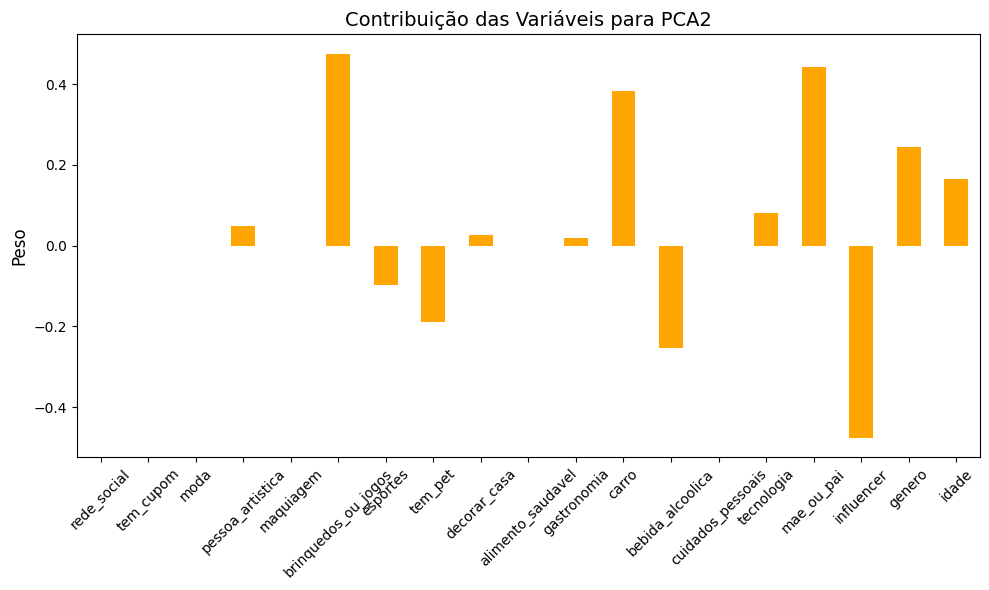

In [27]:
# Obter os loadings (pesos das variáveis para cada componente)
loadings = pd.DataFrame(pca.components_, columns=numeric_columns, index=['PCA1', 'PCA2'])

# Exibir a contribuição das variáveis para os componentes
print("Contribuição das Variáveis para os Componentes Principais:")
print(loadings)

# Visualizar os loadings como um gráfico
plt.figure(figsize=(10, 6))
loadings.loc['PCA1'].plot(kind='bar', color='skyblue')
plt.title('Contribuição das Variáveis para PCA1', fontsize=14)
plt.ylabel('Peso', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
loadings.loc['PCA2'].plot(kind='bar', color='orange')
plt.title('Contribuição das Variáveis para PCA2', fontsize=14)
plt.ylabel('Peso', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# import matplotlib.pyplot as plt

# # Função para criar gráficos de pizza com porcentagem
# def plot_pie(data, column):
#     plt.figure(figsize=(8, 8))
#     data[column].value_counts().plot(
#         kind='pie',
#         autopct='%1.1f%%',
#         startangle=90,
#         colors=plt.cm.Paired.colors
#     )
#     plt.title(f'Distribuição de {column}', fontsize=14)
#     plt.ylabel('')  # Remover o rótulo do eixo y
#     plt.tight_layout()
#     plt.show()



# # Criar gráficos de pizza para as colunas restantes
# for column in columns_to_plot_pie:
#     if column in cluster1.columns:
#         plot_pie(cluster1, column)
